#### 1. 필요 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import torch

import urllib.request

from pororo import Pororo
from sentence_transformers import SentenceTransformer

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
%%time
model = Pororo(task="sentence_embedding", lang="ko")

CPU times: user 4.1 s, sys: 1.16 s, total: 5.26 s
Wall time: 4.92 s


In [4]:
import os
os.listdir('../data')

['nb_table.csv', 'member_mate_2206.csv']

In [5]:
data = pd.read_csv('../data/nb_table.csv')
display(data.head(3))

,mem_no,mem_sex,mem_loc,mem_l_code,mem_birth_year,mem_birth_month,mem_birth_day,mem_birth_slct,mem_birth_ddi,mate_nick,...,reject_hist_no,reject_hist_yn,mem_slct,login_media,list_prt_yn,upd_cnt,conts_upd_cnt,family_conts_upd_cnt,ins_date,upd_date
0,1690114,f,b,b11,1975,7,13,s,7,내짝지님,...,0,n,o,s,n,0,0,0,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956
1,1046726,m,k,k06,1975,2,3,s,7,도란도란,...,0,n,b,s,n,0,0,0,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280
2,1495084,m,b,b13,1989,7,29,s,9,구미복숭아젤링,...,0,n,o,s,n,0,0,0,2022-04-03 20:45:30.778936,2022-04-05 13:12:48.796060


In [6]:
df = data[['mem_no','mem_sex','mem_loc','mem_birth_year','mate_slct','mate_conts','family_conts','ins_date','upd_date']]
display(df.head(3))

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date
0,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956
1,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280
2,1495084,m,b,1989,w,안녕하세요. 저는 부천 있는 중소기업 현장에서 근무하고 있습니다. 나이가 있는 관...,평범한 가족입니다. 아버지 혼자서 저희 키우셨습니다. 그래서 가족 애 가있습니다,2022-04-03 20:45:30.778936,2022-04-05 13:12:48.796060


In [7]:
print(df.shape[0])
df.dropna(inplace=True)
print(df.shape[0])

433
433


/home/yeoai/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 2. 여성/남성 회원 split

In [8]:
df.head(1)

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date
0,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956


In [9]:
class generator:
    
    def __init__(self,df):
        self.df = df

    def split_sex(self,user_df):
        if user_df.loc[:,'mem_sex'][0].lower()=='f':
            target_df= self.df[self.df['mem_sex']=='m'][['mem_no','mem_sex','mem_loc','mem_birth_year','mate_conts','family_conts']].reset_index(drop=True)
        elif user_df.loc[:,'mem_sex'][0].lower() =='m':
            target_df = self.df[self.df['mem_sex']=='f'][['mem_no','mem_sex','mem_loc','mem_birth_year','mate_conts','family_conts']].reset_index(drop=True)
        else:
            raise Exception('Invalid mem_sex value')

        return target_df
    
    def split_age(self,user_df, target_df):
        
        user_age = user_df['mem_birth_year'][0]
        
        if user_df.loc[:,'mem_sex'][0].lower()=='f':
            target_df = target_df.loc[abs(target_df['mem_birth_year']-user_age)<=5]  
        elif user_df.loc[:,'mem_sex'][0].lower() =='m':
            target_df = target_df.loc[abs(target_df['mem_birth_year']-user_age)<=5]
        else:
            raise Exception('Invalid mem_birth_year value')
    
        return target_df
        

**`여성, 남성 sample`**

In [10]:
test_f_df = pd.DataFrame(df.loc[0]).transpose()
test_m_df = pd.DataFrame(df.loc[408]).transpose().reset_index(drop=True)
display(test_f_df)
display(test_m_df)

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date
0,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956


,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date
0,1816776,m,c,1990,w,안녕하세요 소중한 인연을 찾아보려고 가입했어요~ 서로 존중해주고 말이 잘 통하는 그...,"두분다 살아계시구요 중산층?? 금수저, 은수저는 아니지만 평범한 가정에서 부족함없이...",2022-05-12 12:01:48.968657,2022-05-14 18:09:19.106577


#### 4. 임베딩 및 유사도 generator

In [11]:
from sentence_transformers import util

class get_similar_user(generator):
     
    def __init__(self, df):
        self.df = df
               
    def return_df(self,user_df):
        
        def cos_sim(A, B):
            return round(dot(A, B)/(norm(A)*norm(B)), 3)
        
        def calc_similarity(query_embedding, corpus_embeddings):
            cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
            cos_scores = cos_scores.cpu()
            cos_scores = cos_scores.detach().numpy().tolist()[0]
            cos_scores = round(cos_scores, 3)
            return cos_scores    
        

        target_df = self.split_sex(user_df)
        target_df = self.split_age(user_df=user_df,target_df=target_df)
        
        # mate_conts embedding 
        target_df['mate_embedding'] = target_df['mate_conts'].progress_map(model)
        user_emb = model(user_df['mate_conts'][0])  
        target_df['mate_similar_score'] = target_df['mate_embedding'].progress_map(lambda x: calc_similarity(user_emb, x))
        target_df['mate_len'] = target_df['mate_conts'].progress_map(len)
        
        #family_conts embedding
        target_df['family_embedding'] = target_df['family_conts'].progress_map(model)
        user_family_emb = model(user_df['family_conts'][0])       
        target_df['family_similar_score'] = target_df['family_embedding'].progress_map(lambda x: calc_similarity(user_family_emb,x))
        target_df['family_len'] = target_df['family_conts'].progress_map(len)
        
        # 일단 상위 10명 뽑기
        target_df.sort_values(by = ['mate_similar_score', 'family_similar_score'], ascending=[False,False], inplace=True)
        target_df.drop(columns=['mate_embedding','family_embedding'], inplace=True)
        sim_df = target_df[:10].reset_index(drop=True)
        
        
        return sim_df

#### 4. 조건 거르기

In [12]:
class check_condition(get_similar_user):
    
    def __init__(self, df, user_df):
        self.df = df
        self.user_df = user_df
        self.target_df = self.return_df(user_df)
        
    def loc_condition(self):
        user_loc = self.user_df['mem_loc'][0]
        loc_sim_df = self.target_df[self.target_df['mem_loc']==user_loc].reset_index(drop=True)
        
        return loc_sim_df

# 최종

In [13]:
class final_get_user(check_condition):
    
    def __init__(self,df,user_df):
        self.df = df
        self.user_df = user_df
        self.target_df = self.return_df(user_df)
        
    def get_sim_user(self):
        result = self.target_df
        result.reset_index(drop=True)
        
#         print(display(self.user_df))
#         print(self.user_df['mate_conts'][0])
        
#         for idx, row in enumerate(result['mate_conts']):
#             print(idx)
#             print(row)
#             print('------------------------------------------------')
        
        return result
          
    def get_loc_user(self):
        result = self.loc_condition()
        result.reset_index(drop=True)
        
#         print(display(self.user_df))
#         print(self.user_df['mate_conts'][0])
        
#         for idx, row in enumerate(result['mate_conts']):
#             print(idx)
#             print(row)
#             print('------------------------------------------------')
        
        return result
    

In [14]:
fgu = final_get_user(df, test_f_df)

100%|██████████| 123/123 [00:00<00:00, 418409.89it/s]


In [15]:
fgu.get_sim_user()

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_conts,family_conts,mate_similar_score,mate_len,family_similar_score,family_len
0,1804401,m,o,1980,"안녕하세요. ""노력을 값지게 쓰이는분"" 서로 함께 노력 하는분이 였으면 좋겠고 달달...",부모님 모두 건강하시고 살아계십니다. 특히 저희 가족은 모이면 숫자상 상당히 많이 ...,0.778,109,0.634,86
1,1633419,m,n,1980,딱한명이면되는데 그 한사람 찾기가 힘드네요. 제성격은 긍정적이고 즐겁게 살려고 노력...,부모님 두분 다 살아계시고 전주에 살고 계시고 평범한 가족입니다.,0.747,95,0.595,36
2,5,m,i,1977,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다. 같은 취미를 ...,"평범한 가정에서 평온하게 잘 자랐습니다. 가족끼리 돈독하며, 자주 모여 식사를 하거...",0.731,97,0.547,58
3,1794854,m,i,1975,안녕하세요~~^^좋은 인연을 만나기 위해서 가입했어요~~.저는 약간은 내성적이고 내...,부모님은 서울에서 30년이상 사시다가 최근에 파주로 이사해서 건강하게 살고 계시며 ...,0.720,172,0.579,105
4,1832206,m,b,1980,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,0.717,132,0.542,61
5,1304934,m,e,1976,배려와 이해심으로 함께 살아가려고 노력하는 사람입니다. 착하고 현명하신 분이면 좋겠...,"부모님 계시고 2남2녀 중 셋째(둘째아들) 입니다. 모두 결혼하였고, 평범하면서도 ...",0.702,93,0.698,62
6,1565437,m,n,1979,부디..진심을 가지시고 .예의를 갖추시고 배려를 하실줄 아시는 분이길 바랍니다,가족관계 좋습니다. 다들 역활에 열심히 살아갑니다 ...,0.692,43,0.414,33
7,1495544,m,b,1979,좋은분 만나고싶어요 여기서 만날수있을까요진지하게 만나보고싶습니다,아버니은 세종시에 거주하고 어머님은 수지거주 합니다 누나는 결혼 하여잘 살고 있고 ...,0.681,36,0.471,65
8,1698994,m,f,1979,안녕하세요 ~ 밝고 긍정적인 분이 이상형이며 서로 아껴주고 평생 손잡고 싶은 마지막...,"아버지는 5년전 작고하셨고 노후준비되신 어머니 계시며, 동생은 결혼해서 잘 지내고 ...",0.677,82,0.507,72
9,1740297,m,i,1974,안하다 보니 못하게 되는 나이가 되버렷습니다. 아직은 사랑은 이성적인부분 보다 감...,"적당한 관심 과 적당한 거리를 유지하고, 만나서 유쾌하게 티격티격 하고, 서로를 ...",0.675,175,0.321,60


In [16]:
sim_loc_user_df = fgu.get_loc_user()
sim_loc_user_df

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_conts,family_conts,mate_similar_score,mate_len,family_similar_score,family_len
0,1832206,m,b,1980,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,0.717,132,0.542,61
1,1495544,m,b,1979,좋은분 만나고싶어요 여기서 만날수있을까요진지하게 만나보고싶습니다,아버니은 세종시에 거주하고 어머님은 수지거주 합니다 누나는 결혼 하여잘 살고 있고 ...,0.681,36,0.471,65


**`노블 회원 돌리기`**

In [17]:
cols = df.iloc[2].to_frame().transpose().columns.tolist()
cols

['mem_no',
 'mem_sex',
 'mem_loc',
 'mem_birth_year',
 'mate_slct',
 'mate_conts',
 'family_conts',
 'ins_date',
 'upd_date']

In [18]:
temp_m_nb_user_df = pd.DataFrame(columns=cols)
temp_m_nb_user_df

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date


In [19]:
temp_f_nb_user_df = temp_m_nb_user_df.copy()
temp_f_nb_user_df.columns = ['ptr_'+ col for col in temp_f_nb_user_df.columns]
temp_f_nb_user_df

,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_slct,ptr_mate_conts,ptr_family_conts,ptr_ins_date,ptr_upd_date


In [20]:
test_target_df = pd.concat([temp_m_nb_user_df, temp_f_nb_user_df], axis=0)
test_target_df

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_slct,ptr_mate_conts,ptr_family_conts,ptr_ins_date,ptr_upd_date


In [21]:
df_f = df.loc[df['mem_sex']=='f'].reset_index(drop=True)
df_m = df.loc[df['mem_sex']=='m'].reset_index(drop=True)

In [22]:
print(df_f.shape)
print(df_m.shape)

(119, 9)
(314, 9)


### 노블레스 남성 회원 자기소개글 유사도 기반 target 여성 추출

In [23]:
final_target_m = pd.DataFrame()

for i in range(df_m.shape[0]):
    
    temp_m = df_m.iloc[i].to_frame().transpose().reset_index(drop=True)
    target_f_df = final_get_user(df_f, temp_m).get_sim_user()
    
    target_f_df.columns = ['ptr_'+col for col in target_f_df.columns]
    
    final_df = pd.concat([temp_m, target_f_df], axis=1, join='outer').fillna(method='ffill')
    final_target_m = pd.concat([final_target_m, final_df]).reset_index(drop=True)
    
final_target_m

100%|██████████| 3/3 [00:00<00:00, 4288.65it/s]


100%|██████████| 49/49 [00:01<00:00, 47.68it/s]


100%|██████████| 22/22 [00:00<00:00, 86238.03it/s]


100%|██████████| 21/21 [00:00<00:00, 97867.09it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 42/42 [00:01<00:00, 33.42it/s]


100%|██████████| 49/49 [00:00<00:00, 172851.89it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 38/38 [00:01<00:00, 37.78it/s]


100%|██████████| 20/20 [00:00<00:00, 63888.87it/s]


,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_conts,ptr_family_conts,ptr_mate_similar_score,ptr_mate_len,ptr_family_similar_score,ptr_family_len
0,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280,1618734.0,f,i,1973.0,현재의 삶에 만족하며 감사한 마음으로 정갈하게 자신의 내면과 외모를 가꾸며 살아...,어머니는 건강하게 혼자 지내시고 두 남동생 모두전문직 종사자로서 건실한 삶을 살고...,0.710,253.0,0.671,52.0
1,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280,1769669.0,f,i,1979.0,평범한 가정에서 부모님 사랑 많이 받으며 자랐어요. 대구에서 쭉 살다가 대학교를 서...,어머니와 동생은 고향에 있고 동생은 결혼해서 조카도 있어요. 멀리 있는 저대신 동생...,0.703,162.0,0.749,101.0
2,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280,1681380.0,f,i,1976.0,"저는 직업에 대한 자부심이 강했던 탓에 일을 즐기며 살았고, “혼자도 괜찮아”라는 ...","행정공무원이셨던 아빠는 2016년 작고하셨고, 어릴 때부터 제조업을 하셨던 엄마는 ...",0.702,407.0,0.670,130.0
3,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280,1831710.0,f,f,1970.0,"회계사무원, 범생 스타일이며 생활도 반듯한 범생 입니다. 상대도 그러한분이길 바래요...","부모님 두분 다 안계시며, 저만 행복하면 됩니다. 특별히 소개 할 가족은 없어요.",0.699,217.0,0.592,46.0
4,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280,1697955.0,f,b,1974.0,거짓없이 맘의 문을 열고 적극적으로 만남을 시작할 수 있는 분만 연락 주세요. 자가...,"어머니,형제들 인근 지역에 다들 잘 살고 있고 성인 아들 딸들은 전 배우자와 지내고...",0.685,259.0,0.763,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,1779062,m,i,1994,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,2022-05-16 22:41:49.287167,2022-05-16 22:41:49.287167,1654380.0,f,c,1993.0,안녕하세요! 좋은 인연찾고싶어서 가입했습니다ㅏㅏ 잘부탁드려요ㅎㅎㅎㅎ,부모님 두분 다 아픈데 없이 건강하세요ㅎㅎ! 첫째입니닿ㅎㅎ,0.512,37.0,0.349,32.0
3095,1779062,m,i,1994,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,2022-05-16 22:41:49.287167,2022-05-16 22:41:49.287167,1838116.0,f,i,1990.0,"안녕하세요. 저는 진지하게 만나고 싶어서 가입하게 되었습니다. 가정적인 사람, 긍...","가족은 부모님과 언니 남동생이 있습니다. 부모님은 노후준비가 되어있으시고, 언니 ...",0.510,224.0,0.638,97.0
3096,1779062,m,i,1994,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,2022-05-16 22:41:49.287167,2022-05-16 22:41:49.287167,1191871.0,f,e,1990.0,안녕하세요 좋은 분 만나고 싶어서 등록하게 되었습니다. 가볍게 만날 분이 아닌 진지...,화목한 가정입니다. 부모님과 동생 있습니다. 자세한건 친해지면서 공유하면 좋을 것 ...,0.485,66.0,0.602,50.0
3097,1779062,m,i,1994,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,2022-05-16 22:41:49.287167,2022-05-16 22:41:49.287167,1833087.0,f,c,1989.0,안녕하세요^^ 반가워요~ 좋은 인연 만났으면 좋겠어요!,아버지는 진주에서 치과하시고 어머니는 예전에 돌아가셨고 외동입니다,0.436,30.0,0.123,36.0


### 노블레스 남성 회원 지역 유사도 기반 target 여성 추출

In [24]:
final_target_m_df = pd.DataFrame()

for i in range(df_m.shape[0]):
    
    temp_m = df_m.iloc[i].to_frame().transpose().reset_index(drop=True)
    target_f_df = final_get_user(df_f, temp_m).get_loc_user()
    
    target_f_df.columns = ['ptr_'+col for col in target_f_df.columns]
    
    final_df = pd.concat([temp_m, target_f_df], axis=1, join='outer').fillna(method='ffill')
    final_target_m_df = pd.concat([final_target_m_df, final_df]).reset_index(drop=True)
    
final_target_m_df

100%|██████████| 3/3 [00:00<00:00, 3748.26it/s]


100%|██████████| 49/49 [00:01<00:00, 41.76it/s]


100%|██████████| 32/32 [00:00<00:00, 39.07it/s]


100%|██████████| 21/21 [00:00<00:00, 83966.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 42/42 [00:00<00:00, 5506.40it/s]


100%|██████████| 49/49 [00:00<00:00, 210574.69it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 38/38 [00:00<00:00, 7776.70it/s]


100%|██████████| 20/20 [00:00<00:00, 79212.54it/s]


,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_conts,ptr_family_conts,ptr_mate_similar_score,ptr_mate_len,ptr_family_similar_score,ptr_family_len
0,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1495084,m,b,1989,w,안녕하세요. 저는 부천 있는 중소기업 현장에서 근무하고 있습니다. 나이가 있는 관...,평범한 가족입니다. 아버지 혼자서 저희 키우셨습니다. 그래서 가족 애 가있습니다,2022-04-03 20:45:30.778936,2022-04-05 13:12:48.796060,1799065.0,f,b,1984.0,미국에서 석박하고 뉴욕에서 모션그래픽디자이너로 일하다가 한국에서 현재 대학에서 학생...,"사랑많고 저희에게 헌신적이시고 현명한 엄마, 결혼한 착한오빠 한명있어요~!아버지는 ...",0.684,226.0,0.362,94.0
2,1495084,m,b,1989,w,안녕하세요. 저는 부천 있는 중소기업 현장에서 근무하고 있습니다. 나이가 있는 관...,평범한 가족입니다. 아버지 혼자서 저희 키우셨습니다. 그래서 가족 애 가있습니다,2022-04-03 20:45:30.778936,2022-04-05 13:12:48.796060,1829182.0,f,b,1993.0,저는 현재는 보건계열 공무원생활을 하고있구요. 꽤나 감성적이면서도 인생을 잘꾸려나가...,화목하고 따듯한분위기 속에서 컸습니다. 부족함없이 교육시켜주셨고요.,0.619,165.0,0.270,37.0
3,316646,m,e,1976,r,저는 개발자입니다. 저랑 남아있는 생을 행복하게 함께보낼 배우자를 찾습니다.,모두 결혼해서 행복하게 잘 살고 있어요. 🙃😇🤗☺️🥲🙃🥲🤗😗🥲😗🥲😗,2022-03-31 15:12:07.802051,2022-03-31 15:12:07.802051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1155048,m,i,1984,w,자동차 설계 10년차 근무하고 있습니다. 나름 유머러스하고 재미있는 사람이라고 생각...,1남 2녀중 막내입니다 부모님 두분다 교직에 오래계셨고 교장선생님으로 정년퇴임하셨습...,2022-04-27 10:01:20.949169,2022-04-27 16:48:36.933257,1833170.0,f,i,1986.0,안녕하세요~🤗저는 연세대 보건과학대학을 졸업했고 현재 준정부기관에서 근무 중입니다....,아버지는 건설업을 하고 계시고 어머니는 광고사업 후 현재 부동산학과로 대학 진학 후...,0.568,468.0,0.651,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,1541140,m,i,1981,w,"안녕하세요? 앱이라 조심스럽긴 합니다만, 그래도 저의 짝을 찾기위해 등록을 하였네요...",저는 회사일로 서울에서 생활하고 있으며 어머니는 부산에 계십니다. 아버지는 약 10...,2022-05-15 20:16:16.422934,2022-05-15 20:16:16.422934,1826616.0,f,i,1983.0,좀더 솔직하고 신뢰가 가는 사람으로 믿음을 드리고 싶고 그런분을 만나고자 작성해봅니...,어머니는 병원에 계시구 오빠2명 언니1명 있습니다. 오빠1명빼구 모두 결혼해서 화목...,0.516,319.0,0.453,158.0
610,1541140,m,i,1981,w,"안녕하세요? 앱이라 조심스럽긴 합니다만, 그래도 저의 짝을 찾기위해 등록을 하였네요...",저는 회사일로 서울에서 생활하고 있으며 어머니는 부산에 계십니다. 아버지는 약 10...,2022-05-15 20:16:16.422934,2022-05-15 20:16:16.422934,1681380.0,f,i,1976.0,"저는 직업에 대한 자부심이 강했던 탓에 일을 즐기며 살았고, “혼자도 괜찮아”라는 ...","행정공무원이셨던 아빠는 2016년 작고하셨고, 어릴 때부터 제조업을 하셨던 엄마는 ...",0.512,407.0,0.543,130.0
611,743745,m,o,1980,w,"취미생활 공유하며 재미있게 살았으면 좋겠습니다~좋은분 어디없나요^^(동물,자전거 타...",부모님은 충남 공주에 사시며 저는 천안에 5년전 아파트 분양받아 혼자 살고 있어요,2022-05-16 21:11:19.760732,2022-05-16 21:11:19.760732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
612,1779062,m,i,1994,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,2022-05-16 22:41:49.287167,2022-05-16 22:41:49.287167,1742714.0,f,i,1990.0,오랜 유학끝에 이제는 좋은분 만나서 안정적이고 싶습니다. 진중한 분 만나서 같은곳을...,대학 총장이신 아버지 밑에서 엄격하게 매너와 예절을 배웠으며 자애로운 어머니 밑에서...,0.639,135.0,0.471,120.0


### 노블레스 여성 회원 소개글 유사도 기반 target 남성 추출

In [25]:
final_target_f = pd.DataFrame()

for i in range(df_f.shape[0]):
    
    temp_f = df_f.iloc[i].to_frame().transpose().reset_index(drop=True)
    target_m_df = final_get_user(df_m, temp_f).get_sim_user()
    
    temp_f.columns = ['ptr_'+col for col in temp_f.columns]
    
    final_f_df = pd.concat([temp_f, target_m_df], axis=1, join='outer').fillna(method='ffill')
    final_target_f = pd.concat([final_target_f, final_f_df]).reset_index(drop=True)
    

final_target_f

100%|██████████| 155/155 [00:02<00:00, 69.97it/s]


100%|██████████| 155/155 [00:00<00:00, 507507.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 114/114 [00:01<00:00, 81.37it/s]


100%|██████████| 141/141 [00:00<00:00, 494065.88it/s]


,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_slct,ptr_mate_conts,ptr_family_conts,ptr_ins_date,ptr_upd_date,mem_no,mem_sex,mem_loc,mem_birth_year,mate_conts,family_conts,mate_similar_score,mate_len,family_similar_score,family_len
0,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,1804401.0,m,o,1980.0,"안녕하세요. ""노력을 값지게 쓰이는분"" 서로 함께 노력 하는분이 였으면 좋겠고 달달...",부모님 모두 건강하시고 살아계십니다. 특히 저희 가족은 모이면 숫자상 상당히 많이 ...,0.778,109.0,0.634,86.0
1,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,1633419.0,m,n,1980.0,딱한명이면되는데 그 한사람 찾기가 힘드네요. 제성격은 긍정적이고 즐겁게 살려고 노력...,부모님 두분 다 살아계시고 전주에 살고 계시고 평범한 가족입니다.,0.747,95.0,0.595,36.0
2,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,5.0,m,i,1977.0,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다. 같은 취미를 ...,"평범한 가정에서 평온하게 잘 자랐습니다. 가족끼리 돈독하며, 자주 모여 식사를 하거...",0.731,97.0,0.547,58.0
3,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,1794854.0,m,i,1975.0,안녕하세요~~^^좋은 인연을 만나기 위해서 가입했어요~~.저는 약간은 내성적이고 내...,부모님은 서울에서 30년이상 사시다가 최근에 파주로 이사해서 건강하게 살고 계시며 ...,0.720,172.0,0.579,105.0
4,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,1832206.0,m,b,1980.0,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,0.717,132.0,0.542,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,1828698,f,k,1977,r,이제 진정 제사람을 만나고 싶습니다. 기쁜일에 함께 웃고 슬픈일에 같이 울어줄 수있...,소속과 하는일은 다르나 모두 맡은일 책임있게 열심히 하는 착실한 사람들입니다~ 아이...,2022-05-16 20:07:56.580981,2022-05-16 20:07:56.580981,1834157.0,m,e,1972.0,나이드니 소개받기 힘들어서 가입해보았어요. 통신회사에 근무하고 있어요. 차분하고 밝...,3남3녀 모두 잘삽니다. 전문직과 공기업에 근무하며 화목한 분위기입니다.,0.649,281.0,0.385,40.0
1177,1828698,f,k,1977,r,이제 진정 제사람을 만나고 싶습니다. 기쁜일에 함께 웃고 슬픈일에 같이 울어줄 수있...,소속과 하는일은 다르나 모두 맡은일 책임있게 열심히 하는 착실한 사람들입니다~ 아이...,2022-05-16 20:07:56.580981,2022-05-16 20:07:56.580981,1749827.0,m,b,1973.0,받는 사랑보다 주는 사랑이 중요한 남자입니다. 사랑만 하기에도 남은 삶이 부족하다고...,"연로하시지만 비교적 건강하신 부모님, 대기업 임원으로 근무중인 형, 지극히 평범한 ...",0.649,263.0,0.291,52.0
1178,1828698,f,k,1977,r,이제 진정 제사람을 만나고 싶습니다. 기쁜일에 함께 웃고 슬픈일에 같이 울어줄 수있...,소속과 하는일은 다르나 모두 맡은일 책임있게 열심히 하는 착실한 사람들입니다~ 아이...,2022-05-16 20:07:56.580981,2022-05-16 20:07:56.580981,1822100.0,m,f,1974.0,전 프로필에나온것처럼 앞만보보열심히 살았어요 비록 이별의아픔은있지만 더이상 상처주고...,현재 부모님두분다 계시구요 전 아들2명과함께 지내고있습니다 큰아인 20살이며직장인이...,0.636,88.0,0.082,96.0
1179,1828698,f,k,1977,r,이제 진정 제사람을 만나고 싶습니다. 기쁜일에 함께 웃고 슬픈일에 같이 울어줄 수있...,소속과 하는일은 다르나 모두 맡은일 책임있게 열심히 하는 착실한 사람들입니다~ 아이...,2022-05-16 20:07:56.580981,2022-05-16 20:07:56.580981,1795030.0,m,m,1977.0,행복이란 친구를 같이 찾아갈 단 한분을 기다립니다. 소중한 그분과 남은 삶은 모든 ...,모두 자신에 위치에서 행복하게 살아가구 있습니다. 나도 이제 울님과 행복해질 그날만...,0.632,82.0,0.404,54.0


### 노블레스 여성 회원 지역 유사도 기반 target 남성 추출

In [26]:
final_target_f_df = pd.DataFrame()

for i in range(df_f.shape[0]):
    
    temp_f = df_f.iloc[i].to_frame().transpose().reset_index(drop=True)
    target_m_df = final_get_user(df_m, temp_f).get_loc_user()
    
    temp_f.columns = ['ptr_'+col for col in temp_f.columns]
    
    final_f_df = pd.concat([temp_f, target_m_df], axis=1, join='outer').fillna(method='ffill')
    final_target_f_df = pd.concat([final_target_f_df, final_f_df])
    

final_target_f_df

100%|██████████| 132/132 [00:00<00:00, 471993.29it/s]


100%|██████████| 155/155 [00:00<00:00, 504357.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 114/114 [00:00<00:00, 252189.16it/s]


100%|██████████| 141/141 [00:00<00:00, 494065.88it/s]


,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_slct,ptr_mate_conts,ptr_family_conts,ptr_ins_date,ptr_upd_date,mem_no,mem_sex,mem_loc,mem_birth_year,mate_conts,family_conts,mate_similar_score,mate_len,family_similar_score,family_len
0,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,1832206.0,m,b,1980.0,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,0.717,132.0,0.542,61.0
1,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,1495544.0,m,b,1979.0,좋은분 만나고싶어요 여기서 만날수있을까요진지하게 만나보고싶습니다,아버니은 세종시에 거주하고 어머님은 수지거주 합니다 누나는 결혼 하여잘 살고 있고 ...,0.681,36.0,0.471,65.0
0,1817403,f,h,1995,w,🌼🌻🌼 노블레스 테스트 여자 계정입니다 🌻🌼🌻dd,🌻🌼🌻🌼노블레스 테스트 여자 계정입니다🌻🌼🌻🌼dodpdpd,2022-04-04 14:04:30.741009,2022-05-10 16:06:21.549608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1762287,f,p,1965,w,반갑습니다^^ 아직 짝궁이 나타나지 않아 부지런히 찾고 있습니다. 존경할만하며 같은...,양친은 재작년 이후 돌아가시고 남은 자녀는 열씸히 삶을 영위하고 있습니다. 저만 울...,2022-04-24 10:58:22.223305,2022-04-30 09:00:06.619658,1831626.0,m,p,1966.0,건강하며 긍정적인 사고를 가지고 있습니다. 서로 맞는사람 만나서 행복해지고 싶습니다...,부모형제 모두 무고합니다.저만 잘 살면 된다고 합니다.,0.631,68.0,0.472,30.0
0,1596208,f,i,1986,w,안녕하세요 :)몸과 마음을 건강하게 가꾸려고 노력하는 사람이에요. 현재 하는 운동은...,"아빠, 엄마, 남동생, 저까지 4식구로 평범한 가정이에요. 아빠는 막내셔서 저보다 ...",2022-04-04 11:20:49.088346,2022-04-05 13:20:42.129228,1761126.0,m,i,1981.0,안녕하세요.현재 작은 회사운영과 부동산 투자를 겸업하고 있습니다. 금연 중이고 술은...,아버지는 돌아가셨으며 어머니 누나 저 세 식구입니다. 누나는 결혼하여 네명의 자녀들...,0.710,577.0,0.568,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1471628,f,z,1979,w,"수학공부방 하면서 아이들 가르치는 일 하고 있고, 주로 일 하면서 지냅니다. 외모는...","부모님, 여동생부부, 조카, 남동생부부 8식구입니다. 저만 빼고 동생들은 결혼을 ...",2022-05-15 14:12:42.852546,2022-05-15 16:19:16.754238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1711768,f,h,1970,w,안녕하세요 ^^ 신뢰를 최우선으로 생각합니다. 나이에 비해 많이 동안입니다. 어찌하...,"부모님은 2012년, 2015년에 작고하셨습니다. 언니, 형부, 조카 둘 있어요^^...",2022-05-15 14:17:36.596704,2022-05-15 14:17:36.596704,1784831.0,m,h,1967.0,어릴때 할아버지께서 출생신고를 잘못하셔서 누님과 바뀌는 바람에 나이가 두살 많게 되...,너거러우신 모친에 모친께서는 부산 수영구에 따로 살고 계시고 우애깊은 형제 들은 다...,0.611,216.0,0.558,152.0
0,1472787,f,e,1978,w,소중한시간 소중한 사람과 의미있는 시간 만들고 싶어요~,부모님 오빠 평범하고 행복한가족입니다. 가끔 만나고 있어요~^^,2022-05-15 19:18:22.816047,2022-05-15 19:18:22.816047,1304934.0,m,e,1976.0,배려와 이해심으로 함께 살아가려고 노력하는 사람입니다. 착하고 현명하신 분이면 좋겠...,"부모님 계시고 2남2녀 중 셋째(둘째아들) 입니다. 모두 결혼하였고, 평범하면서도 ...",0.640,93.0,0.544,62.0
0,1848250,f,n,1986,w,안녕하세요 ~* 정이 많아서 그런지 헤어짐..그만하고 싶습니다 10년 회사 생활하...,4자매 중 둘째인데요 다들 결혼해서 조카들이 많아요 행복해 보여 부럽기도 해서 ...,2022-05-16 19:54:50.700646,2022-05-16 19:54:50.700646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`전체회원`

In [27]:
display(final_target_f_df.head(1))
display(final_target_m_df.head(1))

,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_slct,ptr_mate_conts,ptr_family_conts,ptr_ins_date,ptr_upd_date,mem_no,mem_sex,mem_loc,mem_birth_year,mate_conts,family_conts,mate_similar_score,mate_len,family_similar_score,family_len
0,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,2022-04-08 17:47:26.931093,2022-04-28 13:10:13.055956,1832206.0,m,b,1980.0,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,0.717,132.0,0.542,61.0


,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,ins_date,upd_date,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_conts,ptr_family_conts,ptr_mate_similar_score,ptr_mate_len,ptr_family_similar_score,ptr_family_len
0,1046726,m,k,1975,w,중소기업이지만 동일업계에서 인정받는 회사에 임원입니다. 안정적인 직장에 안정적인 ...,어머니랑 같이 생활하고 있고 공무원인 여동생은 출가해서 잘살고 있습니다. 둘이 벌이...,2022-04-26 19:12:42.845100,2022-05-09 14:05:28.482280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
set1 = set(final_target_f_df.columns)
set2 = set(final_target_m_df.columns)

total_col = set1.union(set2)
total_col

{'family_conts',
 'family_len',
 'family_similar_score',
 'ins_date',
 'mate_conts',
 'mate_len',
 'mate_similar_score',
 'mate_slct',
 'mem_birth_year',
 'mem_loc',
 'mem_no',
 'mem_sex',
 'ptr_family_conts',
 'ptr_family_len',
 'ptr_family_similar_score',
 'ptr_ins_date',
 'ptr_mate_conts',
 'ptr_mate_len',
 'ptr_mate_similar_score',
 'ptr_mate_slct',
 'ptr_mem_birth_year',
 'ptr_mem_loc',
 'ptr_mem_no',
 'ptr_mem_sex',
 'ptr_upd_date',
 'upd_date'}

In [29]:
total_nb_sim = pd.DataFrame(columns=total_col)
total_nb_sim

,mem_loc,ptr_family_len,mem_sex,ptr_mate_conts,family_conts,mate_len,family_similar_score,ptr_ins_date,ptr_family_similar_score,ins_date,...,mate_slct,mem_no,ptr_family_conts,mate_conts,mate_similar_score,ptr_mem_birth_year,ptr_mem_no,ptr_mate_len,ptr_mate_similar_score,ptr_upd_date


In [30]:
total_nb_sim = pd.concat([total_nb_sim, final_target_f_df])
total_nb_sim = pd.concat([total_nb_sim, final_target_m_df])
total_nb_sim

,mem_loc,ptr_family_len,mem_sex,ptr_mate_conts,family_conts,mate_len,family_similar_score,ptr_ins_date,ptr_family_similar_score,ins_date,...,mate_slct,mem_no,ptr_family_conts,mate_conts,mate_similar_score,ptr_mem_birth_year,ptr_mem_no,ptr_mate_len,ptr_mate_similar_score,ptr_upd_date
0,b,NaN,m,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,132.0,0.542,2022-04-08 17:47:26.931093,NaN,NaN,...,NaN,1832206.0,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,0.717,1975,1690114,NaN,NaN,2022-04-28 13:10:13.055956
1,b,NaN,m,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,아버니은 세종시에 거주하고 어머님은 수지거주 합니다 누나는 결혼 하여잘 살고 있고 ...,36.0,0.471,2022-04-08 17:47:26.931093,NaN,NaN,...,NaN,1495544.0,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,좋은분 만나고싶어요 여기서 만날수있을까요진지하게 만나보고싶습니다,0.681,1975,1690114,NaN,NaN,2022-04-28 13:10:13.055956
0,NaN,NaN,NaN,🌼🌻🌼 노블레스 테스트 여자 계정입니다 🌻🌼🌻dd,NaN,NaN,NaN,2022-04-04 14:04:30.741009,NaN,NaN,...,NaN,NaN,🌻🌼🌻🌼노블레스 테스트 여자 계정입니다🌻🌼🌻🌼dodpdpd,NaN,NaN,1995,1817403,NaN,NaN,2022-05-10 16:06:21.549608
0,p,NaN,m,반갑습니다^^ 아직 짝궁이 나타나지 않아 부지런히 찾고 있습니다. 존경할만하며 같은...,부모형제 모두 무고합니다.저만 잘 살면 된다고 합니다.,68.0,0.472,2022-04-24 10:58:22.223305,NaN,NaN,...,NaN,1831626.0,양친은 재작년 이후 돌아가시고 남은 자녀는 열씸히 삶을 영위하고 있습니다. 저만 울...,건강하며 긍정적인 사고를 가지고 있습니다. 서로 맞는사람 만나서 행복해지고 싶습니다...,0.631,1965,1762287,NaN,NaN,2022-04-30 09:00:06.619658
0,i,NaN,m,안녕하세요 :)몸과 마음을 건강하게 가꾸려고 노력하는 사람이에요. 현재 하는 운동은...,아버지는 돌아가셨으며 어머니 누나 저 세 식구입니다. 누나는 결혼하여 네명의 자녀들...,577.0,0.568,2022-04-04 11:20:49.088346,NaN,NaN,...,NaN,1761126.0,"아빠, 엄마, 남동생, 저까지 4식구로 평범한 가정이에요. 아빠는 막내셔서 저보다 ...",안녕하세요.현재 작은 회사운영과 부동산 투자를 겸업하고 있습니다. 금연 중이고 술은...,0.710,1986,1596208,NaN,NaN,2022-04-05 13:20:42.129228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,i,158,m,좀더 솔직하고 신뢰가 가는 사람으로 믿음을 드리고 싶고 그런분을 만나고자 작성해봅니...,저는 회사일로 서울에서 생활하고 있으며 어머니는 부산에 계십니다. 아버지는 약 10...,NaN,NaN,NaN,0.453,2022-05-15 20:16:16.422934,...,w,1541140.0,어머니는 병원에 계시구 오빠2명 언니1명 있습니다. 오빠1명빼구 모두 결혼해서 화목...,"안녕하세요? 앱이라 조심스럽긴 합니다만, 그래도 저의 짝을 찾기위해 등록을 하였네요...",NaN,1983,1.82662e+06,319,0.516,NaN
610,i,130,m,"저는 직업에 대한 자부심이 강했던 탓에 일을 즐기며 살았고, “혼자도 괜찮아”라는 ...",저는 회사일로 서울에서 생활하고 있으며 어머니는 부산에 계십니다. 아버지는 약 10...,NaN,NaN,NaN,0.543,2022-05-15 20:16:16.422934,...,w,1541140.0,"행정공무원이셨던 아빠는 2016년 작고하셨고, 어릴 때부터 제조업을 하셨던 엄마는 ...","안녕하세요? 앱이라 조심스럽긴 합니다만, 그래도 저의 짝을 찾기위해 등록을 하였네요...",NaN,1976,1.68138e+06,407,0.512,NaN
611,o,NaN,m,NaN,부모님은 충남 공주에 사시며 저는 천안에 5년전 아파트 분양받아 혼자 살고 있어요,NaN,NaN,NaN,NaN,2022-05-16 21:11:19.760732,...,w,743745.0,NaN,"취미생활 공유하며 재미있게 살았으면 좋겠습니다~좋은분 어디없나요^^(동물,자전거 타...",NaN,NaN,NaN,NaN,NaN,NaN
612,i,120,m,오랜 유학끝에 이제는 좋은분 만나서 안정적이고 싶습니다. 진중한 분 만나서 같은곳을...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,NaN,0.471,2022-05-16 22:41:49.287167,...,w,1779062.0,대학 총장이신 아버지 밑에서 엄격하게 매너와 예절을 배웠으며 자애로운 어머니 밑에서...,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,NaN,1990,1.74271e+06,135,0.639,NaN


In [31]:
total_nb_sim = total_nb_sim[['mem_no','mem_sex','mem_loc','mem_birth_year','mate_slct','mate_conts','family_conts',
                  'mate_similar_score','family_similar_score',
                  'ptr_mem_no','ptr_mem_sex','ptr_mem_loc','ptr_mem_birth_year','ptr_mate_slct','ptr_mate_conts',
                  'ptr_family_conts','ptr_mate_similar_score','ptr_family_similar_score'
                 ]]

In [32]:
total_nb_sim.to_csv('total_nb_sim_brain.csv', index=False)

In [33]:
total_nb_sim_loc = pd.DataFrame(columns=total_col)
total_nb_sim_loc

total_nb_sim_loc = pd.concat([total_nb_sim_loc, final_target_f])
total_nb_sim_loc = pd.concat([total_nb_sim_loc, final_target_m])
total_nb_sim_loc

,mem_loc,ptr_family_len,mem_sex,ptr_mate_conts,family_conts,mate_len,family_similar_score,ptr_ins_date,ptr_family_similar_score,ins_date,...,mate_slct,mem_no,ptr_family_conts,mate_conts,mate_similar_score,ptr_mem_birth_year,ptr_mem_no,ptr_mate_len,ptr_mate_similar_score,ptr_upd_date
0,o,NaN,m,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 모두 건강하시고 살아계십니다. 특히 저희 가족은 모이면 숫자상 상당히 많이 ...,109.0,0.634,2022-04-08 17:47:26.931093,NaN,NaN,...,NaN,1804401.0,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,"안녕하세요. ""노력을 값지게 쓰이는분"" 서로 함께 노력 하는분이 였으면 좋겠고 달달...",0.778,1975,1690114,NaN,NaN,2022-04-28 13:10:13.055956
1,n,NaN,m,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분 다 살아계시고 전주에 살고 계시고 평범한 가족입니다.,95.0,0.595,2022-04-08 17:47:26.931093,NaN,NaN,...,NaN,1633419.0,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,딱한명이면되는데 그 한사람 찾기가 힘드네요. 제성격은 긍정적이고 즐겁게 살려고 노력...,0.747,1975,1690114,NaN,NaN,2022-04-28 13:10:13.055956
2,i,NaN,m,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"평범한 가정에서 평온하게 잘 자랐습니다. 가족끼리 돈독하며, 자주 모여 식사를 하거...",97.0,0.547,2022-04-08 17:47:26.931093,NaN,NaN,...,NaN,5.0,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다. 같은 취미를 ...,0.731,1975,1690114,NaN,NaN,2022-04-28 13:10:13.055956
3,i,NaN,m,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님은 서울에서 30년이상 사시다가 최근에 파주로 이사해서 건강하게 살고 계시며 ...,172.0,0.579,2022-04-08 17:47:26.931093,NaN,NaN,...,NaN,1794854.0,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,안녕하세요~~^^좋은 인연을 만나기 위해서 가입했어요~~.저는 약간은 내성적이고 내...,0.720,1975,1690114,NaN,NaN,2022-04-28 13:10:13.055956
4,b,NaN,m,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,132.0,0.542,2022-04-08 17:47:26.931093,NaN,NaN,...,NaN,1832206.0,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,0.717,1975,1690114,NaN,NaN,2022-04-28 13:10:13.055956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,i,32,m,안녕하세요! 좋은 인연찾고싶어서 가입했습니다ㅏㅏ 잘부탁드려요ㅎㅎㅎㅎ,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,NaN,0.349,2022-05-16 22:41:49.287167,...,w,1779062.0,부모님 두분 다 아픈데 없이 건강하세요ㅎㅎ! 첫째입니닿ㅎㅎ,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,NaN,1993,1.65438e+06,37,0.512,NaN
3095,i,97,m,"안녕하세요. 저는 진지하게 만나고 싶어서 가입하게 되었습니다. 가정적인 사람, 긍...",제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,NaN,0.638,2022-05-16 22:41:49.287167,...,w,1779062.0,"가족은 부모님과 언니 남동생이 있습니다. 부모님은 노후준비가 되어있으시고, 언니 ...",안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,NaN,1990,1.83812e+06,224,0.51,NaN
3096,i,50,m,안녕하세요 좋은 분 만나고 싶어서 등록하게 되었습니다. 가볍게 만날 분이 아닌 진지...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,NaN,0.602,2022-05-16 22:41:49.287167,...,w,1779062.0,화목한 가정입니다. 부모님과 동생 있습니다. 자세한건 친해지면서 공유하면 좋을 것 ...,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,NaN,1990,1.19187e+06,66,0.485,NaN
3097,i,36,m,안녕하세요^^ 반가워요~ 좋은 인연 만났으면 좋겠어요!,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,NaN,0.123,2022-05-16 22:41:49.287167,...,w,1779062.0,아버지는 진주에서 치과하시고 어머니는 예전에 돌아가셨고 외동입니다,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,NaN,1989,1.83309e+06,30,0.436,NaN


In [34]:
total_nb_sim_loc[['mem_no','mem_sex','mem_loc','mem_birth_year','mate_slct','mate_conts','family_conts',
                  'mate_similar_score','family_similar_score',
                  'ptr_mem_no','ptr_mem_sex','ptr_mem_loc','ptr_mem_birth_year','ptr_mate_slct','ptr_mate_conts',
                  'ptr_family_conts','ptr_mate_similar_score','ptr_family_similar_score'
                 ]]

,mem_no,mem_sex,mem_loc,mem_birth_year,mate_slct,mate_conts,family_conts,mate_similar_score,family_similar_score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mem_birth_year,ptr_mate_slct,ptr_mate_conts,ptr_family_conts,ptr_mate_similar_score,ptr_family_similar_score
0,1804401.0,m,o,1980.0,NaN,"안녕하세요. ""노력을 값지게 쓰이는분"" 서로 함께 노력 하는분이 였으면 좋겠고 달달...",부모님 모두 건강하시고 살아계십니다. 특히 저희 가족은 모이면 숫자상 상당히 많이 ...,0.778,0.634,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,NaN,NaN
1,1633419.0,m,n,1980.0,NaN,딱한명이면되는데 그 한사람 찾기가 힘드네요. 제성격은 긍정적이고 즐겁게 살려고 노력...,부모님 두분 다 살아계시고 전주에 살고 계시고 평범한 가족입니다.,0.747,0.595,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,NaN,NaN
2,5.0,m,i,1977.0,NaN,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다. 같은 취미를 ...,"평범한 가정에서 평온하게 잘 자랐습니다. 가족끼리 돈독하며, 자주 모여 식사를 하거...",0.731,0.547,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,NaN,NaN
3,1794854.0,m,i,1975.0,NaN,안녕하세요~~^^좋은 인연을 만나기 위해서 가입했어요~~.저는 약간은 내성적이고 내...,부모님은 서울에서 30년이상 사시다가 최근에 파주로 이사해서 건강하게 살고 계시며 ...,0.720,0.579,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,NaN,NaN
4,1832206.0,m,b,1980.0,NaN,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,가족은 부모님 남동생 4 가족이고 부모님께서는 농사를 지으십니다 동생과 둘이 살고 ...,0.717,0.542,1690114,f,b,1975,r,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,부모님 두분다 젊게 사시고 두 동생들 다복하게 잘 살고 있어요,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,1779062.0,m,i,1994.0,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,1.65438e+06,f,c,1993,NaN,안녕하세요! 좋은 인연찾고싶어서 가입했습니다ㅏㅏ 잘부탁드려요ㅎㅎㅎㅎ,부모님 두분 다 아픈데 없이 건강하세요ㅎㅎ! 첫째입니닿ㅎㅎ,0.512,0.349
3095,1779062.0,m,i,1994.0,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,1.83812e+06,f,i,1990,NaN,"안녕하세요. 저는 진지하게 만나고 싶어서 가입하게 되었습니다. 가정적인 사람, 긍...","가족은 부모님과 언니 남동생이 있습니다. 부모님은 노후준비가 되어있으시고, 언니 ...",0.51,0.638
3096,1779062.0,m,i,1994.0,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,1.19187e+06,f,e,1990,NaN,안녕하세요 좋은 분 만나고 싶어서 등록하게 되었습니다. 가볍게 만날 분이 아닌 진지...,화목한 가정입니다. 부모님과 동생 있습니다. 자세한건 친해지면서 공유하면 좋을 것 ...,0.485,0.602
3097,1779062.0,m,i,1994.0,w,안녕하세요! 저는 서울 금천구에 있는 회사에 다니는 회사원입니다. 요즘 코로나로 인...,제 가족은 3살터울 동생한명 아버지 어머니 어렸을때 저를 사랑으로 보듬어주신 외조부...,NaN,NaN,1.83309e+06,f,c,1989,NaN,안녕하세요^^ 반가워요~ 좋은 인연 만났으면 좋겠어요!,아버지는 진주에서 치과하시고 어머니는 예전에 돌아가셨고 외동입니다,0.436,0.123


In [35]:
# total_nb_sim_loc.to_csv('total_nb_sim_loc_brain.csv', index=False)

------------------

In [36]:
data1 = total_nb_sim_loc.copy()

In [37]:
test1 = data1[['mem_no','mem_sex','mem_loc','mate_conts','mate_similar_score', 'ptr_mem_no','ptr_mem_sex', 'ptr_mem_loc','ptr_mate_conts','ptr_mate_similar_score']]
test1.drop(test1[test1['mem_no'].isnull()].index, inplace=True)
test1.drop(test1[test1['ptr_mem_no'].isnull()].index, inplace=True)
test1.reset_index(drop=True, inplace=True)
display(test1.head(3))

/home/yeoai/anaconda3/envs/nlp/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,mem_no,mem_sex,mem_loc,mate_conts,mate_similar_score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts,ptr_mate_similar_score
0,1804401.0,m,o,"안녕하세요. ""노력을 값지게 쓰이는분"" 서로 함께 노력 하는분이 였으면 좋겠고 달달...",0.778,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,NaN
1,1633419.0,m,n,딱한명이면되는데 그 한사람 찾기가 힘드네요. 제성격은 긍정적이고 즐겁게 살려고 노력...,0.747,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,NaN
2,5.0,m,i,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다. 같은 취미를 ...,0.731,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,NaN


In [38]:
test1 = test1.fillna('빈값')

In [39]:
for i in range(test1.shape[0]):
    mate_score = test1.loc[i,'mate_similar_score']
    ptr_score = test1.loc[i,'ptr_mate_similar_score' ]
    
    if ptr_score == '빈값':
        test1.loc[i,'ptr_mate_similar_score'] = mate_score
        
    else:
        test1.loc[i, 'mate_similar_score'] = ptr_score

display(test1.head(2))

,mem_no,mem_sex,mem_loc,mate_conts,mate_similar_score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts,ptr_mate_similar_score
0,1804401.0,m,o,"안녕하세요. ""노력을 값지게 쓰이는분"" 서로 함께 노력 하는분이 였으면 좋겠고 달달...",0.778,1690114.0,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,0.778
1,1633419.0,m,n,딱한명이면되는데 그 한사람 찾기가 힘드네요. 제성격은 긍정적이고 즐겁게 살려고 노력...,0.747,1690114.0,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,0.747


In [40]:
test1.drop(columns=['ptr_mate_similar_score'], inplace=True)
test1.rename(columns={'mate_similar_score' : 'score'}, inplace=True)
test1[['mem_no','ptr_mem_no']] = test1[['mem_no','ptr_mem_no']].astype(int)
display(test1.head(2))

,mem_no,mem_sex,mem_loc,mate_conts,score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts
0,1804401,m,o,"안녕하세요. ""노력을 값지게 쓰이는분"" 서로 함께 노력 하는분이 였으면 좋겠고 달달...",0.778,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...
1,1633419,m,n,딱한명이면되는데 그 한사람 찾기가 힘드네요. 제성격은 긍정적이고 즐겁게 살려고 노력...,0.747,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...


In [41]:
# test_total.to_csv('brainbert.csv', encoding='utf-8-sig',index=False)

#### pos tagging

In [42]:
import re

In [43]:
def basic_preprocessing(df,col):
    df.drop(df[df[col].isnull()].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print('Isnull?', df[col].isnull().sum())
    
    # 공백 제거
    df[col] = df[col].apply(lambda x: x.strip())
    
    # 특수문자, 단모음/단자음 제거
    df[col] = df[col].apply(lambda x: re.sub(r'[\n\r]', '',x))
    df[col] = df[col].apply(lambda x: re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',x))
    df[col] = df[col].apply(lambda x: re.sub('[a-zA-Z]','',x))
    df[col] = df[col].apply(lambda x: re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]','',x))    
    
    # utf-8 encode
    df[col] = df[col].apply(lambda x: x.encode('utf-8','ignore').decode('utf-8'))
    
    # 이모티콘 (이모지) 제거
    def del_emoji (text):
        only_BMP_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
                           "]+", flags=re.UNICODE)
        return only_BMP_pattern.sub(r'', text)
    
    df[col] = df[col].apply(del_emoji)

    return df

In [44]:
pre_df = basic_preprocessing(test1, 'mate_conts')
print(pre_df.shape)
pre_df = basic_preprocessing(pre_df, 'ptr_mate_conts')
print(pre_df.shape)
pre_df.head(3)

Isnull? 0
(4276, 9)
Isnull? 0
(4276, 9)


,mem_no,mem_sex,mem_loc,mate_conts,score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts
0,1804401,m,o,안녕하세요 노력을 값지게 쓰이는분 서로 함께 노력 하는분이 였으면 좋겠고 달달한 인...,0.778,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...
1,1633419,m,n,딱한명이면되는데 그 한사람 찾기가 힘드네요 제성격은 긍정적이고 즐겁게 살려고 노력하...,0.747,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...
2,5,m,i,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다 같은 취미를 공...,0.731,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...


`Okt 확인`

In [45]:
from konlpy.tag import Okt

okt = Okt()

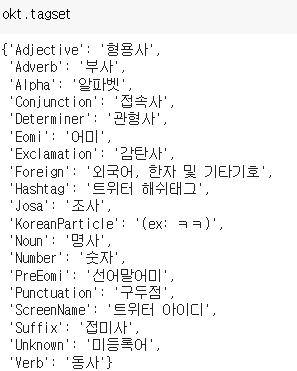

In [46]:
def okt_tokenize(sent):
    try:
        words = okt.pos(sent, join=True)
        words = [w for w in words if ('/Noun' in w) | ('Adjective' in w) | ('Averb' in w)]
        words = [w.split('/')[0] for w in words]
        
    except :
        sent = 'error'
        words = sent
    return words

In [47]:
pre_df['sent1_pos'] = pre_df['mate_conts'].apply(okt_tokenize)
pre_df['sent2_pos'] = pre_df['ptr_mate_conts'].apply(okt_tokenize)

In [48]:
pre_df.head(2)

,mem_no,mem_sex,mem_loc,mate_conts,score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts,sent1_pos,sent2_pos
0,1804401,m,o,안녕하세요 노력을 값지게 쓰이는분 서로 함께 노력 하는분이 였으면 좋겠고 달달한 인...,0.778,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[안녕하세요, 노력, 값지게, 분, 서로, 노력, 분, 좋겠고, 달달, 인연, 살,...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,..."
1,1633419,m,n,딱한명이면되는데 그 한사람 찾기가 힘드네요 제성격은 긍정적이고 즐겁게 살려고 노력하...,0.747,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[명, 그, 사람, 찾기, 힘드네요, 성격, 긍정, 즐겁게, 노력, 사람, 입니다,...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,..."


In [49]:
pre_df['comm'] = ''

In [50]:
def intersection(a,b):
    a = set(a)
    b = set(b)
    return a.intersection(b)

In [51]:
a = set(pre_df.iloc[0]['sent1_pos'])
b = set(pre_df.iloc[0]['sent2_pos'])

In [52]:
for i in range(pre_df.shape[0]):
    a = pre_df.iloc[i]['sent1_pos']
    b = pre_df.iloc[i]['sent2_pos']
    
    result = intersection(a,b)
    result = list(result)
    
    pre_df.at[i,'comm'] = result

In [53]:
pre_df

,mem_no,mem_sex,mem_loc,mate_conts,score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts,sent1_pos,sent2_pos,comm
0,1804401,m,o,안녕하세요 노력을 값지게 쓰이는분 서로 함께 노력 하는분이 였으면 좋겠고 달달한 인...,0.778,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[안녕하세요, 노력, 값지게, 분, 서로, 노력, 분, 좋겠고, 달달, 인연, 살,...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[인연, 노력, 서로]"
1,1633419,m,n,딱한명이면되는데 그 한사람 찾기가 힘드네요 제성격은 긍정적이고 즐겁게 살려고 노력하...,0.747,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[명, 그, 사람, 찾기, 힘드네요, 성격, 긍정, 즐겁게, 노력, 사람, 입니다,...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[서로, 노력, 힘드네요, 사람, 배려]"
2,5,m,i,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다 같은 취미를 공...,0.731,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[조심스럽지만, 인연, 평생, 친구, 연인, 같은, 취미, 공유, 관심사, 같아, ...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[서로, 인연, 친구]"
3,1794854,m,i,안녕하세요좋은 인연을 만나기 위해서 가입했어요저는 약간은 내성적이고 내향적이지만 친...,0.72,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[안녕하세요, 좋은, 인연, 위해, 가입, 저, 약간, 성적, 향, 활동, 성향, ...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[저, 인연, 좋은, 서로]"
4,1832206,m,b,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,0.717,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[없지만, 누구, 배려, 있다고, 자부, 많은, 이성, 많겠지만, 점, 바로, 있습...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[저, 배려, 서로]"
...,...,...,...,...,...,...,...,...,...,...,...,...
4271,1779062,m,i,안녕하세요 저는 서울 금천구에 있는 회사에 다니는 회사원입니다 요즘 코로나로 인하여...,0.512,1654380,f,c,안녕하세요 좋은 인연찾고싶어서 가입했습니다 잘부탁드려요,"[안녕하세요, 저, 서울, 금천구, 있는, 회사, 회사원, 입니다, 요즘, 코로나,...","[안녕하세요, 좋은, 인연, 가입, 부탁드려요]","[안녕하세요, 가입]"
4272,1779062,m,i,안녕하세요 저는 서울 금천구에 있는 회사에 다니는 회사원입니다 요즘 코로나로 인하여...,0.51,1838116,f,i,안녕하세요 저는 진지하게 만나고 싶어서 가입하게 되었습니다 가정적인 사람 긍정적인...,"[안녕하세요, 저, 서울, 금천구, 있는, 회사, 회사원, 입니다, 요즘, 코로나,...","[안녕하세요, 저, 진지하게, 가입, 가정, 사람, 긍정, 사람, 외적인, 모습, ...","[또한, 때, 안녕하세요, 저, 분, 가입, 수, 입니다, 사람, 말, 있는]"
4273,1779062,m,i,안녕하세요 저는 서울 금천구에 있는 회사에 다니는 회사원입니다 요즘 코로나로 인하여...,0.485,1191871,f,e,안녕하세요 좋은 분 만나고 싶어서 등록하게 되었습니다 가볍게 만날 분이 아닌 진지한...,"[안녕하세요, 저, 서울, 금천구, 있는, 회사, 회사원, 입니다, 요즘, 코로나,...","[안녕하세요, 좋은, 분, 등록, 가볍게, 만날, 분, 아닌, 진지한, 마음, 분만...","[분, 안녕하세요, 연락]"
4274,1779062,m,i,안녕하세요 저는 서울 금천구에 있는 회사에 다니는 회사원입니다 요즘 코로나로 인하여...,0.436,1833087,f,c,안녕하세요 반가워요 좋은 인연 만났으면 좋겠어요,"[안녕하세요, 저, 서울, 금천구, 있는, 회사, 회사원, 입니다, 요즘, 코로나,...","[안녕하세요, 반가워요, 좋은, 인연, 좋겠어요]",[안녕하세요]


In [54]:
pre_du = pre_df.drop_duplicates(subset=['mem_no'],keep='first')
pre_du

,mem_no,mem_sex,mem_loc,mate_conts,score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts,sent1_pos,sent2_pos,comm
0,1804401,m,o,안녕하세요 노력을 값지게 쓰이는분 서로 함께 노력 하는분이 였으면 좋겠고 달달한 인...,0.778,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[안녕하세요, 노력, 값지게, 분, 서로, 노력, 분, 좋겠고, 달달, 인연, 살,...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[인연, 노력, 서로]"
1,1633419,m,n,딱한명이면되는데 그 한사람 찾기가 힘드네요 제성격은 긍정적이고 즐겁게 살려고 노력하...,0.747,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[명, 그, 사람, 찾기, 힘드네요, 성격, 긍정, 즐겁게, 노력, 사람, 입니다,...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[서로, 노력, 힘드네요, 사람, 배려]"
2,5,m,i,조심스럽지만 인연이 된다면 평생을 친구처럼 연인처럼 함께하고싶습니다 같은 취미를 공...,0.731,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[조심스럽지만, 인연, 평생, 친구, 연인, 같은, 취미, 공유, 관심사, 같아, ...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[서로, 인연, 친구]"
3,1794854,m,i,안녕하세요좋은 인연을 만나기 위해서 가입했어요저는 약간은 내성적이고 내향적이지만 친...,0.72,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[안녕하세요, 좋은, 인연, 위해, 가입, 저, 약간, 성적, 향, 활동, 성향, ...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[저, 인연, 좋은, 서로]"
4,1832206,m,b,가진것은 많이 없지만 누구보다 배려해줄수 있다고 자부합니다 많은 이성을 사귀지를 않...,0.717,1690114,f,b,좋은 인연을 만나기가 참 힘드네요 서로 배려해주고 아껴주는 친구처럼 편안한 사람...,"[없지만, 누구, 배려, 있다고, 자부, 많은, 이성, 많겠지만, 점, 바로, 있습...","[좋은, 인연, 힘드네요, 서로, 배려, 친구, 편안한, 사람, 저, 그런, 사람,...","[저, 배려, 서로]"
...,...,...,...,...,...,...,...,...,...,...,...,...
4136,1838097,m,i,먼저 오는분이 나의 공주님으로 당첨 늦으시면 문이닫혀요 어서오세요,0.579,1770674,f,i,안녕하세요방갑습니다 여기서좋은분을 꼭만나고싶네요제 영원한 반쪽이있을까요,"[먼저, 분, 나, 공주, 당첨, 문, 어서]","[안녕하세요, 방, 여기, 좋은, 분, 꼭, 제, 영원한, 반쪽, 있을까요]",[분]
4166,1846540,m,i,반려견과 동행은 이제 그만 함께 또는 반려자와 함께 하는 삶을 희망합니다,0.603,1817134,f,b,곁에 있던 가족들 떠나거나 자기의 미래를 위해 열심히 살고 저만 남았네요 첨엔 일하...,"[반려견, 동행, 이제, 반려자, 삶, 희망]","[곁, 있던, 가족, 자기, 미래, 위해, 살, 첨, 일, 바빴는데, 요즘, 혼자,...",[]
4216,1761202,m,b,안녕하세요 진심으로 만나보고 싶습니다 거짓장난 사절합니다 딱한 분만 나타나 주세요,0.592,1741169,f,i,안녕하세요 가입 한지 꽤 지났는데도 아직 인연을 만나지 못했습니다 아무래도 늦은 ...,"[안녕하세요, 진심, 보고, 거짓, 장난, 사절, 딱한, 분만]","[안녕하세요, 가입, 한지, 꽤, 인연, 나이, 새롭게, 인연, 하니, 신중하게, ...",[안녕하세요]
4246,1541140,m,i,안녕하세요 앱이라 조심스럽긴 합니다만 그래도 저의 짝을 찾기위해 등록을 하였네요 글...,0.643,1741169,f,i,안녕하세요 가입 한지 꽤 지났는데도 아직 인연을 만나지 못했습니다 아무래도 늦은 ...,"[안녕하세요, 앱, 조심스럽긴, 저, 짝, 찾기, 위해, 등록, 글, 소개, 사진,...","[안녕하세요, 가입, 한지, 꽤, 인연, 나이, 새롭게, 인연, 하니, 신중하게, ...","[저, 안녕하세요]"


In [55]:
pre_du.loc[pre_du['mem_no']==743745].reset_index(drop=True)

,mem_no,mem_sex,mem_loc,mate_conts,score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts,sent1_pos,sent2_pos,comm
0,743745,m,o,취미생활 공유하며 재미있게 살았으면 좋겠습니다좋은분 어디없나요동물자전거 타기스노우보...,0.644,1688393,f,i,서로 믿고 소소한 일상을 공유할 동반자를 찾습니다 혼자도 좋지만 두 사람이 긍정의 ...,"[취미, 생활, 공유, 재미있게, 좋겠습니다, 좋은, 분, 어디, 없나요, 동물, ...","[서로, 소소한, 일상, 공유, 동반, 혼자, 좋지만, 두, 사람, 긍정, 시너지,...","[분, 공유]"


In [70]:
pre_du1 = pre_du.copy()
pre_du1.columns = ['ptr_mem_no', 'ptr_mem_sex', 'ptr_mem_loc', 'ptr_mate_conts', 'score', 'mem_no',
       'mem_sex', 'mem_loc', 'mate_conts', 'sent1_pos','sent2_pos', 'comm']

print(pre_du1.shape)

pre_du = pd.concat([pre_du, pre_du1])
pre_du

print(pre_du.shape)

(312, 12)
(624, 12)


In [56]:
pre_du.columns

Index(['mem_no', 'mem_sex', 'mem_loc', 'mate_conts', 'score', 'ptr_mem_no',
       'ptr_mem_sex', 'ptr_mem_loc', 'ptr_mate_conts', 'sent1_pos',
       'sent2_pos', 'comm'],
      dtype='object')

In [76]:
def target_user_representation(mem_no):
    
    temp_df = pre_du.loc[pre_du['mem_no']==mem_no].reset_index(drop=True)
    
    print('회원번호 : ', temp_df.loc[0, 'mem_no'])
    print('성별 : ', temp_df.loc[0, 'mem_sex'])
    print('작성한 자기소개글 : ', temp_df.loc[0, 'mate_conts'])
    
    print('------------------------------------------------------------------------------------------------------------------------')
    
    print('상대와의 소개글 유사도 : ', temp_df.loc[0,'score'])
    print('어떤 단어들이 유사했을까요? :', temp_df.loc[0,'comm'])
    
    print('------------------------------------------------------------------------------------------------------------------------')
    
    print('상대 회원 번호 : ', temp_df.loc[0,'ptr_mem_no'])
    print('상대 회원 성별 : ', temp_df.loc[0, 'ptr_mem_sex'])
    print('상대가 작성한 자기소개글 : ', temp_df.loc[0, 'ptr_mate_conts'])
    
    print('------------------------------------------------------------------------------------------------------------------------')

In [87]:
pre_du.sort_values(by='comm', ascending=False)

,mem_no,mem_sex,mem_loc,mate_conts,score,ptr_mem_no,ptr_mem_sex,ptr_mem_loc,ptr_mate_conts,sent1_pos,sent2_pos,comm
1035,1733340,m,h,미국방부소속 한국인 직원으로 자부심과 열정적으로 일하며 유흥도박게임흡연은 일체 하지...,0.723,1842533,f,i,순수 열정 청순 섹시 유쾌 다재다능 하단소리 듣습니다 미국에서 공부하고 일한후 한국...,"[미국방부, 소속, 한국인, 직원, 자부심, 열정, 일, 유흥, 도박, 게임, 흡연...","[순수, 열정, 청순, 섹시, 유쾌, 다재, 능, 하단, 소리, 미국, 공부, 후,...","[흡연, 제, 좋은, 사람, 생각, 분, 열정, 배려, 자기]"
1035,1842533,f,i,순수 열정 청순 섹시 유쾌 다재다능 하단소리 듣습니다 미국에서 공부하고 일한후 한국...,0.723,1733340,m,h,미국방부소속 한국인 직원으로 자부심과 열정적으로 일하며 유흥도박게임흡연은 일체 하지...,"[미국방부, 소속, 한국인, 직원, 자부심, 열정, 일, 유흥, 도박, 게임, 흡연...","[순수, 열정, 청순, 섹시, 유쾌, 다재, 능, 하단, 소리, 미국, 공부, 후,...","[흡연, 제, 좋은, 사람, 생각, 분, 열정, 배려, 자기]"
373,412865,m,k,안녕하세요인천에 살고 평범하다 생각하는 보통 남성입니다서로 살아 온 환경이 다르니 ...,0.695,1803565,f,i,시크해 보이지만 알고보면 다정하고 타인을 배려하는 성격입니다 천진난만한 어린아이같은...,"[안녕하세요, 인천, 살, 평범하다, 생각, 보통, 남성, 입니다, 서로, 살, 온...","[시크, 보이, 알, 다정하고, 타인, 배려, 성격, 입니다, 천진난만한, 같은, ...","[흡연, 살, 저, 스타일, 분, 알, 수, 입니다, 사람, 배려, 있는]"
373,1803565,f,i,시크해 보이지만 알고보면 다정하고 타인을 배려하는 성격입니다 천진난만한 어린아이같은...,0.695,412865,m,k,안녕하세요인천에 살고 평범하다 생각하는 보통 남성입니다서로 살아 온 환경이 다르니 ...,"[안녕하세요, 인천, 살, 평범하다, 생각, 보통, 남성, 입니다, 서로, 살, 온...","[시크, 보이, 알, 다정하고, 타인, 배려, 성격, 입니다, 천진난만한, 같은, ...","[흡연, 살, 저, 스타일, 분, 알, 수, 입니다, 사람, 배려, 있는]"
1923,1700219,m,i,안녕하세요 대기업에서 24년간 근무하고 있으며 해외에서 8년간 근무했고 내년 쯤 다...,0.578,1842533,f,i,순수 열정 청순 섹시 유쾌 다재다능 하단소리 듣습니다 미국에서 공부하고 일한후 한국...,"[안녕하세요, 대기업, 근무, 있으며, 해외, 근무, 내년, 쯤, 다시, 해외, 근...","[순수, 열정, 청순, 섹시, 유쾌, 다재, 능, 하단, 소리, 미국, 공부, 후,...","[후, 있습니다, 생활]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2093,1839973,m,k,,0.398,1751412,f,c,안녕하세요 노블레스는 뭔가 다를까요 궁금하네요 서로를 알아볼 수 있었으면 좋겠습니다...,[],"[안녕하세요, 노블레스, 뭔가, 다를까, 요, 궁금하네요, 서로, 수, 있었으면, ...",[]
156,1784831,m,h,어릴때 할아버지께서 출생신고를 잘못하셔서 누님과 바뀌는 바람에 나이가 두살 많게 되...,0.597,1702453,f,b,안녕하세요 두아이 대학졸업 잘시키고 취업까지 시키고 나니 너무나도 홀가분해지고 잘 ...,"[때, 할아버지, 출생신고, 잘못, 누님, 바람, 나이, 살, 많게, 있지만, 나이...","[안녕하세요, 아이, 대학, 졸업, 취업, 나니, 홀가분해지고, 그동안, 바빠서, ...",[]
496,1814472,f,f,일과 육아로 바쁘게 살아 왔지만 늘 최선을 다하며 살았고 그속에서 더 성장했고 ...,0.677,1698591,m,c,애들 다 성장하고 제 인생 다시 해보려합니다 같이 하는걸 좋아합니다,"[애, 성장하고, 제, 인생, 다시, 는걸, 좋아합니다]","[일과, 육아, 바쁘게, 살, 늘, 최선, 속, 더, 성장했고, 나름, 지혜, 워,...",[]
336,1654904,m,g,재즈와 와인을 좋아하는 요색남입니다 현재 외식 프렌차이즈 유통업 대표를 겸하고 있구...,0.569,1632497,f,d,165에 표준체형 비흡연이예요함께 운동이나 취미생활할수 있는 분이면좋겠어요맛집투어 ...,"[재즈, 와인, 좋아하는, 색남, 입니다, 현재, 외식, 프렌, 차, 이즈, 유통업...","[표준, 체형, 비, 흡연, 운동, 취미, 생활, 있는, 좋겠어요, 맛집, 투어, ...",[]


In [88]:
target_user_representation(1733340)

회원번호 :  1733340
성별 :  m
작성한 자기소개글 :  미국방부소속 한국인 직원으로 자부심과 열정적으로 일하며 유흥도박게임흡연은 일체 하지 않고 가끔 와인 한잔정도 유머있고 유쾌하며 한편으론 신중하기도 합니다 수영과축구로 과건강은 잘 유지하고 있으며 나름의 소신들안에서 자유롭게 지냅니다 외롭다고 아무나 만나지 아니하고 한 사람만 보는 해바라기형이라서 만나서 아니다라고 생각이들면 정중히 돌아설 줄도 압니다 찾는 여성분은 기본소양 갖추고 자기직업 가지고 깊이 있고 말의 온도도 있는 분이구요이쁘기까지 한다면 금상첨화겠죠아 소심답답까칠예민한분은 못만나요그리고 성급한 재혼보단 아름답고 행복한 시간들을 먼저 많이 가지고 싶습니다기념일엔 꽃과 손편지도 드리구싶구손잡고 여행도 다니구 싶구 영화도 맛집도 이쁜 까페도같이 하고 싶은게 많네요평일주말 모두 시간 여유롭고 휴가도 자유로워서 평일 여행도 가능해요 청소 설겆이 밥등 집안 일들도 잘하고 유연하고 합리적인 사고로 타인의 입장에 서서 늘 먼저 생각하고 배려하려고 노력하며 제 부족한 점이 있다면 그 또한 고쳐가는 노력도 아끼지 않습니다  서로 호감 가지면 여기서 백날 챗하는것 보다 얼굴보며 커피한잔 하는게 맞다고 생각하구요혹시 제 프로필 읽고 계실 제 반쪽을 위해 정성스레 이글을 적는 것이니 어떤 끌림이 있다면 적극적인 문자 한통 남겨주세요 저두 좋은 분 눈에 띄면 적극 대쉬할께요저 만나 행복받고 저 또한 행복해지고 싶어요
------------------------------------------------------------------------------------------------------------------------
상대와의 소개글 유사도 :  0.723
어떤 단어들이 유사했을까요? : ['흡연', '제', '좋은', '사람', '생각', '분', '열정', '배려', '자기']
------------------------------------------------------------------

In [90]:
target_user_representation(412865)

회원번호 :  412865
성별 :  m
작성한 자기소개글 :  안녕하세요인천에 살고 평범하다 생각하는 보통 남성입니다서로 살아 온 환경이 다르니 많은 차이가 있을것 입니다 서로가 다름을 인정하고 조금씩 양보하며 배려하고 이해심이 있으셨으면 좋겠습니다내가 가지고 있는 조건에서 가치관이 비슷한 분을 만났으면 합니다몇장의 사진과 몇줄의 소개글로 그 사람을 알 수 있을까요 서로를 알기에는 만나보는게 좋겠지만 낯 설으시면 대화라도 천천히 하시겠어요전 여러번 본 다음 다가가는 스타일입니다제가 선택한 분은 저만의 미인이시겠죠저보다 연상이신분흡연자분자녀 있으신분은 죄송합니다
------------------------------------------------------------------------------------------------------------------------
상대와의 소개글 유사도 :  0.695
어떤 단어들이 유사했을까요? : ['흡연', '살', '저', '스타일', '분', '알', '수', '입니다', '사람', '배려', '있는']
------------------------------------------------------------------------------------------------------------------------
상대 회원 번호 :  1803565
상대 회원 성별 :  f
상대가 작성한 자기소개글 :  시크해 보이지만 알고보면 다정하고 타인을 배려하는 성격입니다 천진난만한 어린아이같은 면도 있고 은근슬쩍 관심을 필요로 하고 누가 챙겨주는 것을 좋아해요  키가 큰 것이 특징이고174 정년은 보장된 직장 다니고 있습니다 호적에 한살 많게되어있는데 실제는 76년생입니다대인관계에 내성적인 편이라 사실 새로운 사람 만나는 걸 편하게 느끼진 않지만  그래도 이젠  일상을 공감하고 사랑할 수 있는 분 만나고 싶어요 다정다감하고 편안한 스타일로 저를 리드해줄 수 있는 분 자기가 한 말은 잘지키려 노력하는 신뢰감 있는 

In [92]:
target_user_representation(1700219)

회원번호 :  1700219
성별 :  m
작성한 자기소개글 :  안녕하세요 대기업에서 24년간 근무하고 있으며 해외에서 8년간 근무했고 내년 쯤 다시 해외 근무 예정입니다 경제적으로 안정되어 있고 컴퓨터 및 어플 잘 사용하고 최신 기술에 관심이 많습니다  를 선호하고 회사 은퇴 후 전원 생활 꿈꾸고 있습니다 182 76
------------------------------------------------------------------------------------------------------------------------
상대와의 소개글 유사도 :  0.578
어떤 단어들이 유사했을까요? : ['후', '있습니다', '생활']
------------------------------------------------------------------------------------------------------------------------
상대 회원 번호 :  1842533
상대 회원 성별 :  f
상대가 작성한 자기소개글 :  순수 열정 청순 섹시 유쾌 다재다능 하단소리 듣습니다 미국에서 공부하고 일한후 한국온지는 10년 됬으며  쭉 직장생활 하고 있습니다 그래서 그런지 좋은 뜻으로 한국 여자들과 다르다는말 많이 들어요  남성분  키 177이상 72년생 미만 필수조건이며 대졸 비흡연자 자기관리 운동 잘하는 사회적으로 자신감 있으신 분 가벼운 만남  원하지 않고 한 사람만 진중히 만나는 결혼 생각 있으신 분만 희망합니다♡  제가 선택한 분은 배려하고 존중하고 사랑 많이 드릴 거에요 인생의 즐거움 함께해요
------------------------------------------------------------------------------------------------------------------------
